In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

In [4]:
data_path = "dataset/data_clean.csv"

df_clean = pd.read_csv(data_path)

df_clean.head()

,SeniorCitizen,MonthlyCharges,TotalCharges_log,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cohort_12-24 Months,tenure_cohort_24-48 Months,tenure_cohort_Over 48 Months,Churn
0,0,29.85,3.429137,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,7.544597,1,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,0,53.85,4.692723,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,42.30,7.518471,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,5.028148,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1


In [30]:
neg, pos = np.bincount(df_clean["Churn"])
total = pos + neg

print(f'Examples:\n  Total: {total}\n  Positive: {pos} ({100 * pos / total}%)\n  Negative: {neg} ({100 * neg / total}%)')

Examples:
  Total: 7032
  Positive: 1869 (26.57849829351536%)
  Negative: 5163 (73.42150170648465%)


In [7]:
df_train, df_test = train_test_split(df_clean, test_size=0.1)

df_train, df_val = train_test_split(df_train, test_size=0.1)

train_labels = np.array(df_train.pop("Churn"))
bool_train_labels = train_labels != 0
val_labels = np.array(df_val.pop("Churn"))
test_labels = np.array(df_test.pop("Churn"))

train_feat = np.array(df_train)
val_feat = np.array(df_val)
test_feat = np.array(df_test)

train_feat.shape, val_feat.shape, test_feat.shape

((5695, 32), (633, 32), (704, 32))

In [8]:
scaler = StandardScaler()

train_feat = np.clip(scaler.fit_transform(train_feat), -5, 5)
val_feat = np.clip(scaler.transform(val_feat), -5, 5)
test_feat = np.clip(scaler.transform(test_feat), -5, 5)

In [ ]:
# pca = PCA(0.95)

In [10]:
baseline = RandomForestClassifier()

baseline.fit(train_feat, train_labels)

baseline_preds = baseline.predict(val_feat)

In [11]:
roc_auc_score(val_labels, baseline_preds)

0.6890157942827307

In [12]:
print(classification_report(val_labels, baseline_preds))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       470
           1       0.60      0.49      0.54       163

    accuracy                           0.79       633
   macro avg       0.72      0.69      0.70       633
weighted avg       0.77      0.79      0.78       633



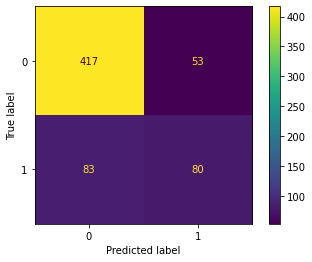

In [13]:
ConfusionMatrixDisplay.from_estimator(baseline, val_feat, val_labels)

In [14]:
search = {
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [25, 50, 75, 100, 150],
            "max_depth": [2, 3, 4, 5, 6],
            "criterion": ["entropy", "gini"]
        }
    },
    "ada_boost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [25, 50, 75, 100, 150],
            "learning_rate": [0.05, 0.1, 0.3, 0.5]
        }
    },
    "gradient_boost": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [25, 50, 75, 100, 150],
            "learning_rate": [0.05, 0.1, 0.3, 0.5],
            "max_depth": [2, 3, 4, 5, 6]
        }
    }
}

In [16]:
scores = []

for name, clf in search.items():
    grid = GridSearchCV(
        estimator=clf["model"],
        param_grid=clf["params"],
        cv=3,
        return_train_score=False,
        n_jobs=-1,
        refit=False,
        verbose=3
    )
    grid.fit(train_feat, train_labels)
    scores.append({
        "name": name,
        "best_params": grid.best_params_,
        "best_score": grid.best_score_
    })

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [17]:
scores

[{'name': 'random_forest',
  'best_params': {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100},
  'best_score': 0.801931506664351},
 {'name': 'ada_boost',
  'best_params': {'learning_rate': 0.3, 'n_estimators': 100},
  'best_score': 0.8077261561323108},
 {'name': 'gradient_boost',
  'best_params': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150},
  'best_score': 0.8063212609080298}]

In [18]:
best_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.3)

best_model.fit(train_feat, train_labels)

best_model.score(val_feat, val_labels)

0.8120063191153238

In [19]:
preds = best_model.predict(val_feat)

roc_auc_score(val_labels, preds)

0.731144759169821

In [20]:
print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       470
           1       0.66      0.56      0.61       163

    accuracy                           0.81       633
   macro avg       0.76      0.73      0.74       633
weighted avg       0.80      0.81      0.81       633



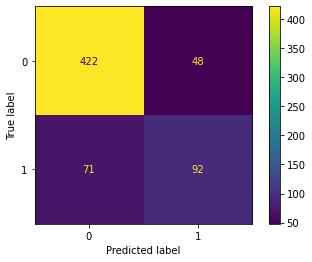

In [21]:
ConfusionMatrixDisplay.from_estimator(best_model, val_feat, val_labels)

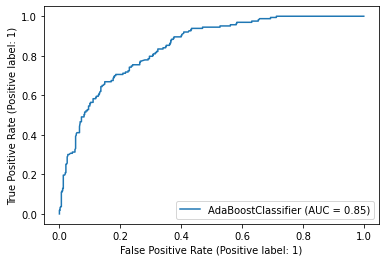

In [23]:
RocCurveDisplay.from_estimator(best_model, val_feat, val_labels)

### Test set score

In [29]:
best_model.score(test_feat, test_labels)

0.7997159090909091

In [24]:
test_preds = best_model.predict(test_feat)

In [25]:
roc_auc_score(test_labels, test_preds)

0.6974932815932381

In [26]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       537
           1       0.59      0.50      0.54       167

    accuracy                           0.80       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.79      0.80      0.79       704



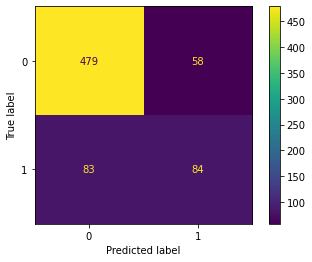

In [27]:
ConfusionMatrixDisplay.from_estimator(best_model, test_feat, test_labels)

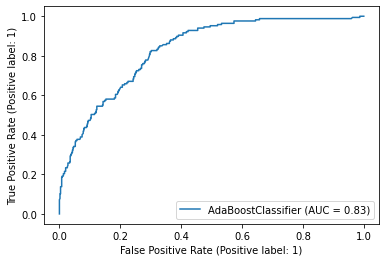

In [28]:
RocCurveDisplay.from_estimator(best_model, test_feat, test_labels)